In [1]:
%pylab inline
import pandas as pd
import dask.dataframe as dd

Populating the interactive namespace from numpy and matplotlib


In [2]:
import dask.array as da
import datetime 
import gc
from multiprocessing import pool
import cPickle as pickle
import os

In [3]:
sample=pd.read_csv("../input/sample_submission.csv")

In [4]:
sample.shape

(9463187, 5)

In [5]:
parcelids=sample['ParcelId'].values
len(parcelids)

9463187

In [6]:
df=dd.read_parquet("../input/home_attributes_history/home_attributes_2017_v1.parq")[['parcelid','rawcensustractandblock']] 
df['state']=df['rawcensustractandblock'].map(lambda u: str(u)[:2])
df=df.drop('rawcensustractandblock',axis=1).compute()
df=df.set_index('parcelid')
df.shape

(9463187, 1)

In [7]:
df['state'].value_counts()

39    3111391
37    2932874
06    1809321
36     829379
19     732280
na      47942
Name: state, dtype: int64

In [8]:
df=df[df['state']=='37']
df.shape

(2932874, 1)

In [9]:
filename='tax_history_2007to2017_v2.parq'

In [10]:
data=dd.read_parquet("../input/"+filename).drop(
    ['landappraisedvalue','improvementappraisedvalue','taxdelinquencyamount','totalappraisedvalue'],axis=1
).compute().set_index("parcelid")

In [11]:
print data.shape
data=data.loc[df.index]
print data.shape

(84932226, 14)
(25840247, 14)


In [12]:
#set(data.assessmentyear)

In [13]:
years=[2007, 2008, 2009, 2010, 2011, 2012, 2013, 2014, 2015, 2016, 2017]

In [14]:
data_dict={u:data[data['assessmentyear']==u] for u in 
           years}

In [15]:
for i in years:
    print i, data_dict[i].shape[0]

2007 1954010
2008 1985405
2009 2037923
2010 2540726
2011 2602464
2012 2572285
2013 2363471
2014 2416002
2015 2709655
2016 2798611
2017 1859695


In [16]:
lst=[]
for i in years:
    lst.append(data_dict[i].isnull().mean())
tmpdf=pd.concat(lst,axis=1)
tmpdf.columns=years
tmpdf

2007      2008      2009      2010      2011  \
assessmentyear              0.000000  0.000000  0.000000  0.000000  0.000000   
taxratecodearea             0.853093  0.851909  0.896817  0.876113  0.873303   
improvementmarketvalue      0.284992  0.272335  0.294314  0.281327  0.285318   
structuretaxvaluedollarcnt  0.067134  0.058205  0.072423  0.050132  0.057492   
totalassessedvalue          0.305015  0.302139  0.135452  0.114307  0.107315   
taxamount                   0.824486  0.823578  0.861034  0.892668  0.831921   
taxvaluedollarcnt           0.013316  0.011178  0.004143  0.003564  0.002197   
edition                     0.000000  0.000000  0.000000  0.000000  0.000000   
landassessedvalue           0.413650  0.405227  0.288148  0.293513  0.307105   
taxdelinquencyyear          1.000000  1.000000  1.000000  0.999212  0.992382   
totalmarketvalue            0.249624  0.236559  0.249545  0.250796  0.251118   
improvementassessedvalue    0.439352  0.430082  0.310802  0.309751  0.324729   
landtaxvaluedollarcnt       0.037796  0.029141  0.050205  0.025271  0.035798   
landmarketvalue             0.266738  0.254221  0.281716  0.263650  0.268738   

                                2012      2013      2014      2015      2016  \
assessmentyear              0.000000  0.000000  0.000000  0.000000  0.000000   
taxratecodearea             0.873183  0.882069  0.892812  0.870450  0.889171   
improvementmarketvalue      0.291212  0.224465  0.253838  0.241161  0.233300   
structuretaxvaluedollarcnt  0.059277  0.038727  0.062144  0.069932  0.062647   
totalassessedvalue          0.107653  0.100153  0.070918  0.042465  0.040299   
taxamount                   0.873975  0.829923  0.094984  0.088998  0.097900   
taxvaluedollarcnt           0.003007  0.006130  0.003560  0.003405  0.004918   
edition                     0.000000  0.000000  0.000000  0.000000  0.000000   
landassessedvalue           0.324962  0.319633  0.295206  0.283754  0.299521   
taxdelinquencyyear          0.975617  0.811967  0.956154  0.962238  0.966032   
totalmarketvalue            0.257235  0.197374  0.214344  0.192980  0.165745   
improvementassessedvalue    0.346233  0.333189  0.308412  0.295356  0.307391   
landtaxvaluedollarcnt       0.038439  0.021034  0.036886  0.047348  0.047320   
landmarketvalue             0.274874  0.210440  0.232123  0.220219  0.218366   

                                2017  
assessmentyear              0.000000  
taxratecodearea             0.873938  
improvementmarketvalue      0.214418  
structuretaxvaluedollarcnt  0.054414  
totalassessedvalue          0.014746  
taxamount                   0.063324  
taxvaluedollarcnt           0.003054  
edition                     0.000000  
landassessedvalue           0.238823  
taxdelinquencyyear          0.972416  
totalmarketvalue            0.172241  
improvementassessedvalue    0.250018  
landtaxvaluedollarcnt       0.034929  
landmarketvalue             0.194825

In [17]:
def get_col(col):
    df=pd.concat([data_dict[i][col] for i in years],axis=1)
    df.columns=years
    return df

In [18]:
print "Are there ones whose tax is not null but taxvalue is null?"
a=get_col("taxamount")
b=get_col("taxvaluedollarcnt")

Are there ones whose tax is not null but taxvalue is null?


In [19]:
for year in years:
    aa=a.loc[:,year]
    bb=b.loc[:,year]
    ab=pd.concat([aa,bb],axis=1)
    num=np.sum((~ab.iloc[:,0].isnull()) & ab.iloc[:,1].isnull())
    print year,num,ab.shape[0],float(num)/ab.shape[0]
    #break

2007 13 2932874 4.43251227294e-06
2008 0 2932874 0.0
2009 0 2932874 0.0
2010 414 2932874 0.000141158467769
2011 971 2932874 0.000331074570541
2012 982 2932874 0.000334825157849
2013 1144 2932874 0.000390061080019
2014 4687 2932874 0.00159809115564
2015 3963 2932874 0.00135123431828
2016 6488 2932874 0.00221216458668
2017 851 2932874 0.000290159072637


In [20]:
print "how assesed values varies with market value?"
c=get_col('totalassessedvalue')
d=get_col('totalmarketvalue')

how assesed values varies with market value?


In [21]:
for year in years:
    aa=c.loc[:,year]
    bb=d.loc[:,year]
    ab=pd.concat([aa,bb],axis=1)
    n1=np.sum((~ab.iloc[:,0].isnull()) & ab.iloc[:,1].isnull())
   
    n2=np.sum((ab.iloc[:,0].isnull()) & ~ab.iloc[:,1].isnull())
    n3=np.sum((~ab.iloc[:,0].isnull()) & ~ab.iloc[:,1].isnull())
    n4=data_dict[year].shape[0]
    if n4<1: 
        print year, 'missing'
        continue     
    print year,n1,n2,n3,n4,np.round([float(n1)/n4,float(n2)/n4,float(n3)/n4,float(n4-n1-n2-n3)/n4],3)

2007 461747 569982 896261 1954010 [ 0.236  0.292  0.459  0.013]
2008 447473 577677 938063 1985405 [ 0.225  0.291  0.472  0.011]
2009 500111 267597 1261772 2037923 [ 0.245  0.131  0.619  0.004]
2010 628148 281369 1622154 2540726 [ 0.247  0.111  0.638  0.004]
2011 647807 273566 1675373 2602464 [ 0.249  0.105  0.644  0.002]
2012 653947 269180 1641424 2572285 [ 0.254  0.105  0.638  0.003]
2013 452001 222221 1674762 2363471 [ 0.191  0.094  0.709  0.006]
2014 509255 162737 1735409 2416002 [ 0.211  0.067  0.718  0.004]
2015 513683 105839 2080906 2709655 [ 0.19   0.039  0.768  0.003]
2016 450093 99017 2235737 2798611 [ 0.161  0.035  0.799  0.005]
2017 314635 21743 1517637 1859695 [ 0.169  0.012  0.816  0.003]


In [22]:
for year in years:
    aa=c.loc[:,year]
    bb=d.loc[:,year]
    ab=pd.concat([aa,bb],axis=1)
    ind=(~ab.iloc[:,0].isnull()) & ~ab.iloc[:,1].isnull()
    n1=np.sum(ind)
    if n1<1: 
        print year, 'missing'
        continue
    n2=np.sum( ind & (ab.iloc[:,0]>ab.iloc[:,1]))
    n3=np.sum( ind & (ab.iloc[:,0]<ab.iloc[:,1]))
    ne=np.sum( ind & (ab.iloc[:,0]==ab.iloc[:,1]))
    n4=data_dict[year].shape[0]
    
    print year,n1,n2,n3,n4,np.round([float(n1)/n4,float(n2)/n1,float(n3)/n1,float(ne)/n1],3) 
    

2007 896261 229 10426 1954010 [ 0.459  0.     0.012  0.988]
2008 938063 2964 13979 1985405 [ 0.472  0.003  0.015  0.982]
2009 1261772 280 14564 2037923 [ 0.619  0.     0.012  0.988]
2010 1622154 10028 15488 2540726 [ 0.638  0.006  0.01   0.984]
2011 1675373 4038 19074 2602464 [ 0.644  0.002  0.011  0.986]
2012 1641424 5930 20601 2572285 [ 0.638  0.004  0.013  0.984]
2013 1674762 3273 19685 2363471 [ 0.709  0.002  0.012  0.986]
2014 1735409 7170 23767 2416002 [ 0.718  0.004  0.014  0.982]
2015 2080906 28610 45994 2709655 [ 0.768  0.014  0.022  0.964]
2016 2235737 20867 103602 2798611 [ 0.799  0.009  0.046  0.944]
2017 1517637 5254 65218 1859695 [ 0.816  0.003  0.043  0.954]


In [26]:
print """
     
"""

look at their difference
2007 896261 10655 [ 0.459  0.012]


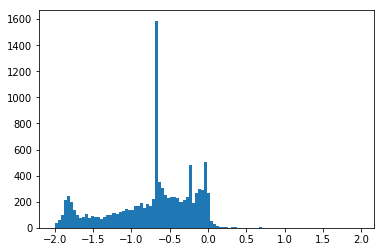

2008 938063 16943 [ 0.472  0.018]


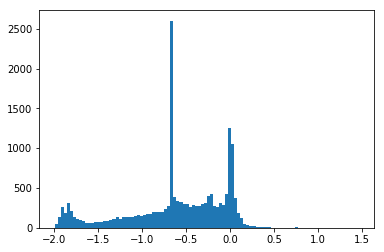

2009 1261772 14844 [ 0.619  0.012]


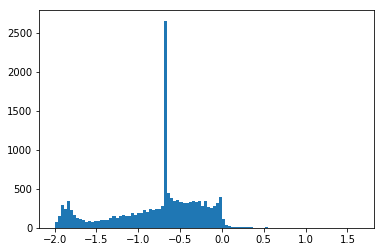

2010 1622154 25516 [ 0.638  0.016]


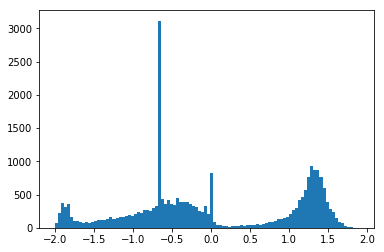

2011 1675373 23112 [ 0.644  0.014]


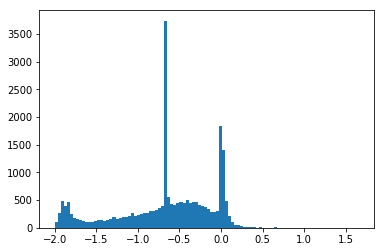

2012 1641424 26531 [ 0.638  0.016]


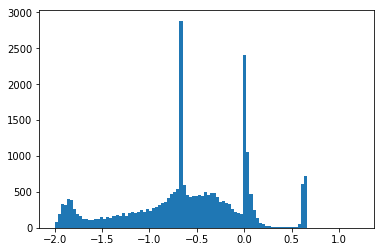

2013 1674762 22958 [ 0.709  0.014]


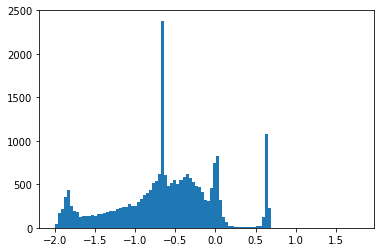

2014 1735409 30937 [ 0.718  0.018]


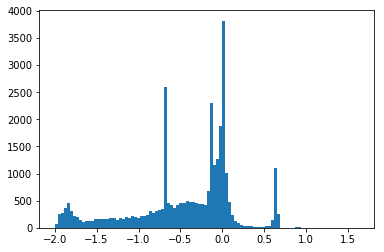

2015 2080906 74604 [ 0.768  0.036]


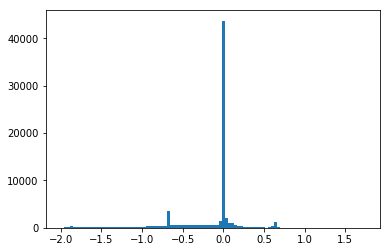

2016 2235737 124469 [ 0.799  0.056]


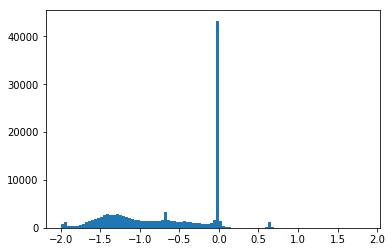

2017 1517637 70472 [ 0.816  0.046]


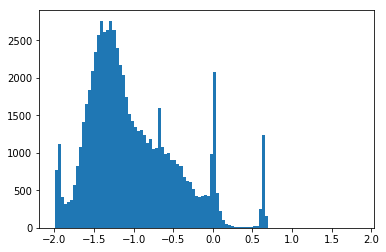

In [24]:
print "look at their difference"
for year in years:
    aa=c.loc[:,year]
    bb=d.loc[:,year]
    ab=pd.concat([aa,bb],axis=1)
    ind=(~ab.iloc[:,0].isnull()) & ~ab.iloc[:,1].isnull()
    n1=np.sum(ind)
    if n1<1: 
        print year, 'missing'
        continue    
    ind2= ( ind & (ab.iloc[:,0]<>ab.iloc[:,1]))
    n2=np.sum(ind2)
    n4=data_dict[year].shape[0]
    print year,n1,n2,np.round([float(n1)/n4,float(n2)/n1],3) 
    difference=2*(aa[ind2]-bb[ind2])/(aa[ind2]+bb[ind2])
    plt.hist(difference,bins=100);plt.show()
    #break

In [27]:
print """

"""

### landassessedvalue vs  landmarketvalue

In [28]:
print "how assesed values varies with market value?"
c=get_col('landassessedvalue')
d=get_col('landmarketvalue')

how assesed values varies with market value?


In [29]:
for year in years:
    aa=c.loc[:,year]
    bb=d.loc[:,year]
    ab=pd.concat([aa,bb],axis=1)
    n1=np.sum((~ab.iloc[:,0].isnull()) & ab.iloc[:,1].isnull())
    n2=np.sum((ab.iloc[:,0].isnull()) & ~ab.iloc[:,1].isnull())
    n3=np.sum((~ab.iloc[:,0].isnull()) & ~ab.iloc[:,1].isnull())
    n4=data_dict[year].shape[0]
    if n4<1: 
        print year, 'missing'
        continue     
    print year,n1,n2,n3,n4,np.round([float(n1)/n4,float(n2)/n4,float(n3)/n4,float(n4-n1-n2-n3)/n4],3)

2007 447355 734423 698379 1954010 [ 0.229  0.376  0.357  0.038]
2008 446874 746683 733991 1985405 [ 0.225  0.376  0.37   0.029]
2009 471803 484911 978896 2037923 [ 0.232  0.238  0.48   0.05 ]
2010 605655 681528 1189336 2540726 [ 0.238  0.268  0.468  0.025]
2011 606218 706066 1197016 2602464 [ 0.233  0.271  0.46   0.036]
2012 608177 737019 1128213 2572285 [ 0.236  0.287  0.439  0.038]
2013 447657 705730 1160371 2363471 [ 0.189  0.299  0.491  0.021]
2014 471692 624102 1231091 2416002 [ 0.195  0.258  0.51   0.037]
2015 468419 640577 1472361 2709655 [ 0.173  0.236  0.543  0.047]
2016 478691 705814 1481676 2798611 [ 0.171  0.252  0.529  0.047]
2017 297358 379180 1118199 1859695 [ 0.16   0.204  0.601  0.035]


In [30]:
for year in years:
    aa=c.loc[:,year]
    bb=d.loc[:,year]
    ab=pd.concat([aa,bb],axis=1)
    ind=(~ab.iloc[:,0].isnull()) & ~ab.iloc[:,1].isnull()
    n1=np.sum(ind)
    if n1<1: 
        print year, 'missing'
        continue        
    n2=np.sum( ind & (ab.iloc[:,0]>ab.iloc[:,1]))
    n3=np.sum( ind & (ab.iloc[:,0]<ab.iloc[:,1]))
    ne=np.sum( ind & (ab.iloc[:,0]==ab.iloc[:,1]))
    n4=data_dict[year].shape[0]
    
    print year,n1,n2,n3,n4,np.round([float(n1)/n4,float(n2)/n1,float(n3)/n1,float(ne)/n1],3) 

2007 698379 68 5772 1954010 [ 0.357  0.     0.008  0.992]
2008 733991 24 3587 1985405 [ 0.37   0.     0.005  0.995]
2009 978896 42 3315 2037923 [ 0.48   0.     0.003  0.997]
2010 1189336 152 6426 2540726 [ 0.468  0.     0.005  0.994]
2011 1197016 23 7745 2602464 [ 0.46   0.     0.006  0.994]
2012 1128213 31 7497 2572285 [ 0.439  0.     0.007  0.993]
2013 1160371 25 7094 2363471 [ 0.491  0.     0.006  0.994]
2014 1231091 581 6987 2416002 [ 0.51   0.     0.006  0.994]
2015 1472361 21377 30264 2709655 [ 0.543  0.015  0.021  0.965]
2016 1481676 17066 28750 2798611 [ 0.529  0.012  0.019  0.969]
2017 1118199 5 2375 1859695 [ 0.601  0.     0.002  0.998]


In [31]:
print """

"""

look at their difference
2007 698379 5840 [ 0.357  0.008]


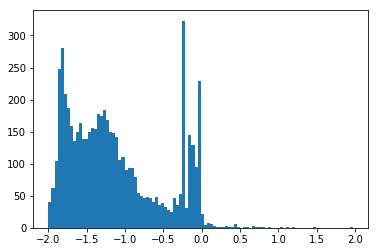

2008 733991 3611 [ 0.37   0.005]


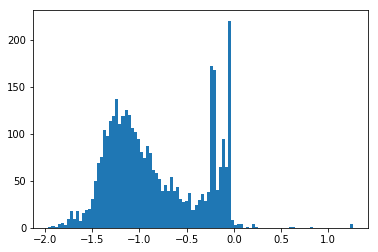

2009 978896 3357 [ 0.48   0.003]


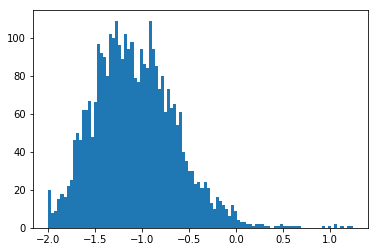

2010 1189336 6578 [ 0.468  0.006]


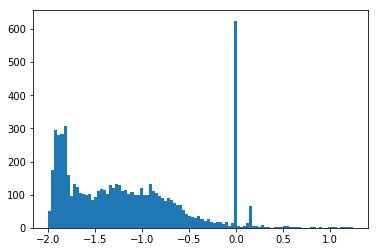

2011 1197016 7768 [ 0.46   0.006]


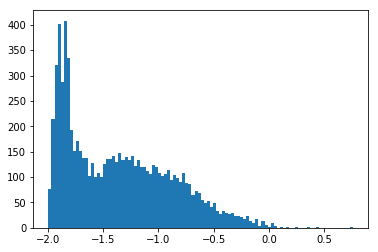

2012 1128213 7528 [ 0.439  0.007]


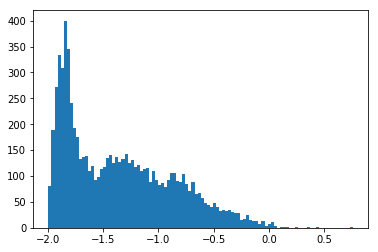

2013 1160371 7119 [ 0.491  0.006]


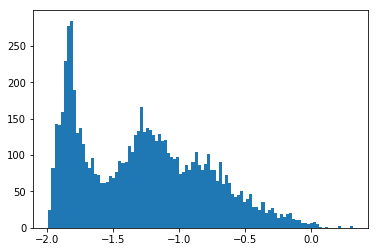

2014 1231091 7568 [ 0.51   0.006]


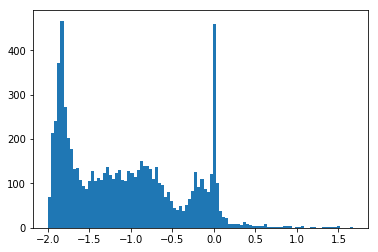

2015 1472361 51641 [ 0.543  0.035]


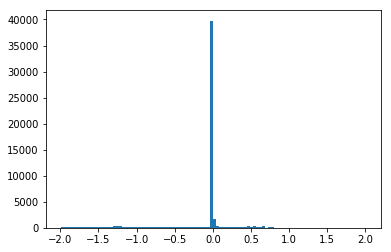

2016 1481676 45816 [ 0.529  0.031]


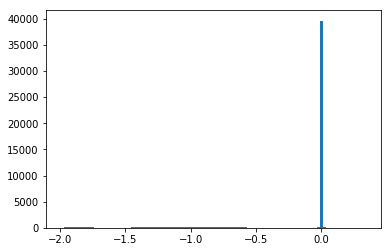

2017 1118199 2380 [ 0.601  0.002]


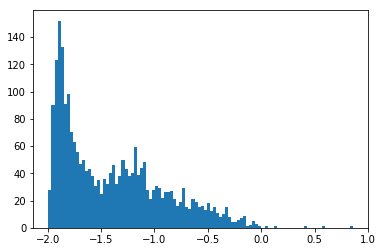

In [32]:
print "look at their difference"
for year in years:
    aa=c.loc[:,year]
    bb=d.loc[:,year]
    ab=pd.concat([aa,bb],axis=1)
    ind=(~ab.iloc[:,0].isnull()) & ~ab.iloc[:,1].isnull()
    n1=np.sum(ind)
    if n1<1: 
        print year, 'missing'
        continue        
    ind2= ( ind & (ab.iloc[:,0]<>ab.iloc[:,1]))
    n2=np.sum(ind2)
    n4=data_dict[year].shape[0]
    print year,n1,n2,np.round([float(n1)/n4,float(n2)/n1],3) 
    difference=2*(aa[ind2]-bb[ind2])/(aa[ind2]+bb[ind2])
    plt.hist(difference,bins=100);plt.show()
    #break

In [33]:
print """

"""

### landassessedvalue vs  landmarketvalue

In [34]:
print "how assesed values varies with market value?"
c=get_col('improvementassessedvalue')
d=get_col('improvementmarketvalue')

how assesed values varies with market value?


In [35]:
for year in years:
    aa=c.loc[:,year]
    bb=d.loc[:,year]
    ab=pd.concat([aa,bb],axis=1)
    n1=np.sum((~ab.iloc[:,0].isnull()) & ab.iloc[:,1].isnull())
    n2=np.sum((ab.iloc[:,0].isnull()) & ~ab.iloc[:,1].isnull())
    n3=np.sum((~ab.iloc[:,0].isnull()) & ~ab.iloc[:,1].isnull())
    n4=data_dict[year].shape[0]
    if n4<1: 
        print year, 'missing'
        continue    
    print year,n1,n2,n3,n4,np.round([float(n1)/n4,float(n2)/n4,float(n3)/n4,float(n4-n1-n2-n3)/n4],3)

2007 425697 727318 669814 1954010 [ 0.218  0.372  0.343  0.067]
2008 425135 738327 706383 1985405 [ 0.214  0.372  0.356  0.058]
2009 452196 485797 952337 2037923 [ 0.222  0.238  0.467  0.072]
2010 587404 659621 1166330 2540726 [ 0.231  0.26   0.459  0.05 ]
2011 592909 695476 1164459 2602464 [ 0.228  0.267  0.447  0.057]
2012 596603 738132 1085073 2572285 [ 0.232  0.287  0.422  0.059]
2013 438986 695952 1137002 2363471 [ 0.186  0.294  0.481  0.039]
2014 463134 594984 1207745 2416002 [ 0.192  0.246  0.5    0.062]
2015 463971 610822 1445370 2709655 [ 0.171  0.225  0.533  0.07 ]
2016 477591 684942 1460753 2798611 [ 0.171  0.245  0.522  0.063]
2017 297558 363763 1097180 1859695 [ 0.16   0.196  0.59   0.054]


In [36]:
for year in years:
    aa=c.loc[:,year]
    bb=d.loc[:,year]
    ab=pd.concat([aa,bb],axis=1)
    ind=(~ab.iloc[:,0].isnull()) & ~ab.iloc[:,1].isnull()
    n1=np.sum(ind)
    if n1<1: 
        print year, 'missing'
        continue        
    n2=np.sum( ind & (ab.iloc[:,0]>ab.iloc[:,1]))
    n3=np.sum( ind & (ab.iloc[:,0]<ab.iloc[:,1]))
    ne=np.sum( ind & (ab.iloc[:,0]==ab.iloc[:,1]))
    n4=data_dict[year].shape[0]
    
    print year,n1,n2,n3,n4,np.round([float(n1)/n4,float(n2)/n1,float(n3)/n1,float(ne)/n1],3) 

2007 669814 118 2316 1954010 [ 0.343  0.     0.003  0.996]
2008 706383 89 1801 1985405 [ 0.356  0.     0.003  0.997]
2009 952337 107 1548 2037923 [ 0.467  0.     0.002  0.998]
2010 1166330 1185 4675 2540726 [ 0.459  0.001  0.004  0.995]
2011 1164459 0 3 2602464 [ 0.447  0.     0.     1.   ]
2012 1085073 0 1 2572285 [ 0.422  0.     0.     1.   ]
2013 1137002 64 437 2363471 [ 0.481  0.     0.     1.   ]
2014 1207745 876 3116 2416002 [ 0.5    0.001  0.003  0.997]
2015 1445370 4921 3036 2709655 [ 0.533  0.003  0.002  0.994]
2016 1460753 52 48433 2798611 [ 0.522  0.     0.033  0.967]
2017 1097180 40 48802 1859695 [ 0.59   0.     0.044  0.955]


In [37]:
print """

"""

look at their difference
2007 669814 2434 [ 0.343  0.004]


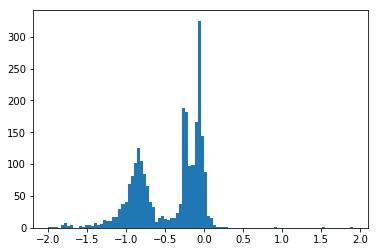

2008 706383 1890 [ 0.356  0.003]


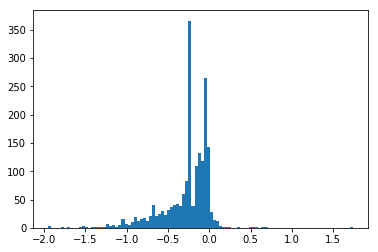

2009 952337 1655 [ 0.467  0.002]


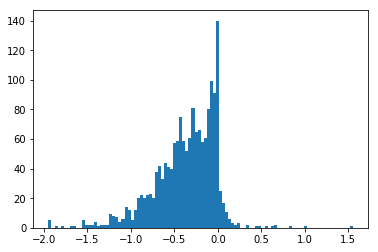

2010 1166330 5860 [ 0.459  0.005]


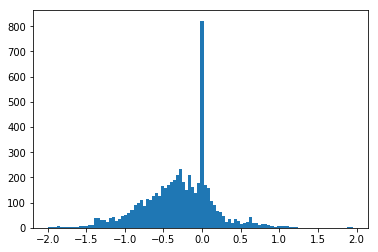

2011 1164459 3 [ 0.447  0.   ]


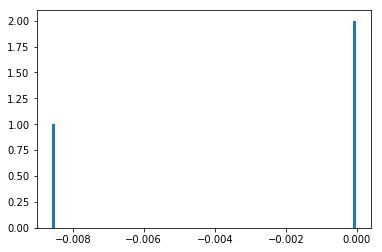

2012 1085073 1 [ 0.422  0.   ]


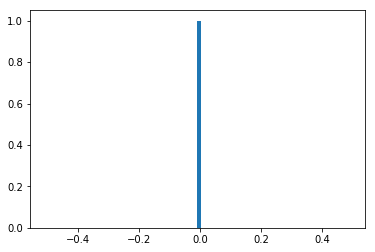

2013 1137002 501 [ 0.481  0.   ]


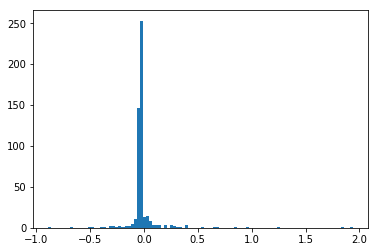

2014 1207745 3992 [ 0.5    0.003]


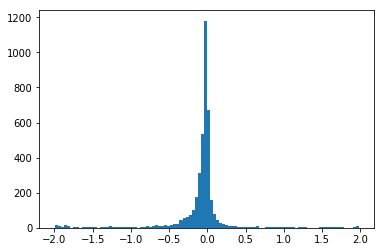

2015 1445370 7957 [ 0.533  0.006]


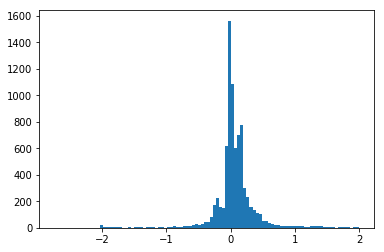

2016 1460753 48485 [ 0.522  0.033]


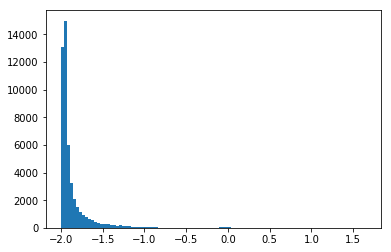

2017 1097180 48842 [ 0.59   0.045]


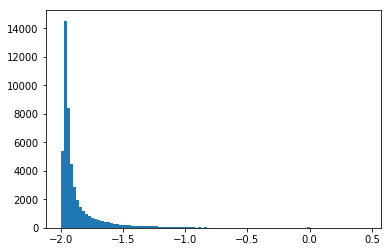

In [38]:
print "look at their difference"
for year in years:
    aa=c.loc[:,year]
    bb=d.loc[:,year]
    ab=pd.concat([aa,bb],axis=1)
    ind=(~ab.iloc[:,0].isnull()) & ~ab.iloc[:,1].isnull()
    n1=np.sum(ind)
    if n1<1: 
        print year, 'missing'
        continue        
    ind2= ( ind & (ab.iloc[:,0]<>ab.iloc[:,1]))
    n2=np.sum(ind2)
    n4=data_dict[year].shape[0]
    print year,n1,n2,np.round([float(n1)/n4,float(n2)/n1],3) 
    difference=2*(aa[ind2]-bb[ind2])/(aa[ind2]+bb[ind2])
    plt.hist(difference,bins=100);plt.show()
    #break

In [39]:
print """

"""

### land vs total

In [42]:
c=get_col('improvementassessedvalue')
d=get_col('landassessedvalue')

In [43]:
for year in years:
    aa=c.loc[:,year]
    bb=d.loc[:,year]
    ab=pd.concat([aa,bb],axis=1)
    n1=np.sum((~ab.iloc[:,0].isnull()) & ab.iloc[:,1].isnull())
    n2=np.sum((ab.iloc[:,0].isnull()) & ~ab.iloc[:,1].isnull())
    n3=np.sum((~ab.iloc[:,0].isnull()) & ~ab.iloc[:,1].isnull())
    n4=data_dict[year].shape[0]
    if n4<1: 
        print year, 'missing'
        continue    
    print year,n1,n2,n3,n4,np.round([float(n1)/n4,float(n2)/n4,float(n3)/n4,float(n4-n1-n2-n3)/n4],3)

2007 8304 58527 1087207 1954010 [ 0.004  0.03   0.556  0.409]
2008 5538 54885 1125980 1985405 [ 0.003  0.028  0.567  0.402]
2009 11734 57900 1392799 2037923 [ 0.006  0.028  0.683  0.282]
2010 18501 59758 1735233 2540726 [ 0.007  0.024  0.683  0.286]
2011 13416 59282 1743952 2602464 [ 0.005  0.023  0.67   0.302]
2012 12701 67415 1668975 2572285 [ 0.005  0.026  0.649  0.32 ]
2013 20063 52103 1555925 2363471 [ 0.008  0.022  0.658  0.311]
2014 18967 50871 1651912 2416002 [ 0.008  0.021  0.684  0.287]
2015 32380 63819 1876961 2709655 [ 0.012  0.024  0.693  0.272]
2016 29933 51956 1908411 2798611 [ 0.011  0.019  0.682  0.289]
2017 11548 32367 1383190 1859695 [ 0.006  0.017  0.744  0.233]


In [44]:
print "most of them are null consistent   "

most of them are null consistent   


look at their ratio
2007 1087207 [ 0.556] 0.0 0.0


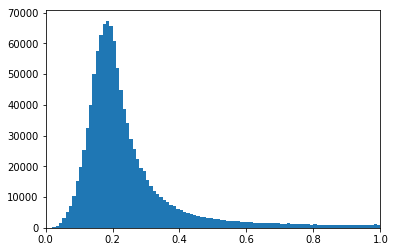

2008 1125980 [ 0.567] 0.0 0.0


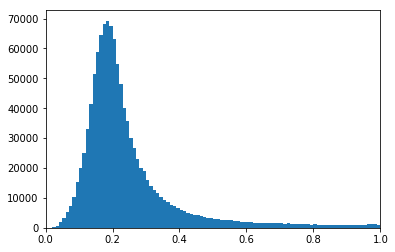

2009 1392799 [ 0.683] 0.0 0.0


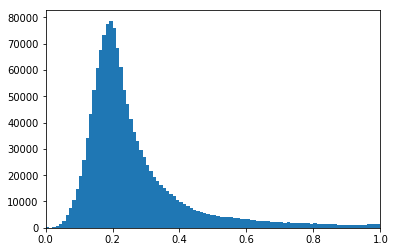

2010 1735233 [ 0.683] 0.0 0.0


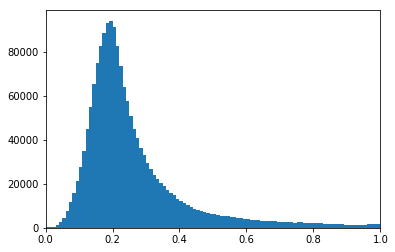

2011 1743952 [ 0.67] 0.0 0.0


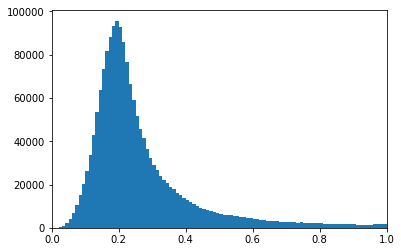

2012 1668975 [ 0.649] 0.0 0.0


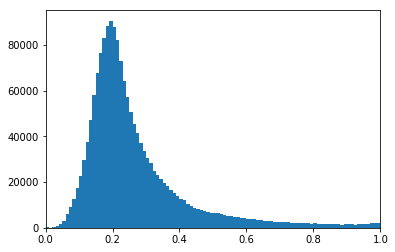

2013 1555925 [ 0.658] 0.0 0.0


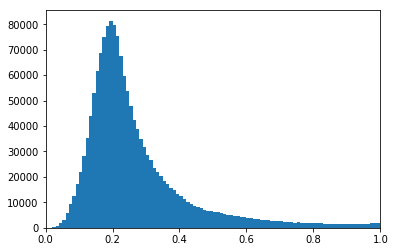

2014 1651912 [ 0.684] 0.0 0.0


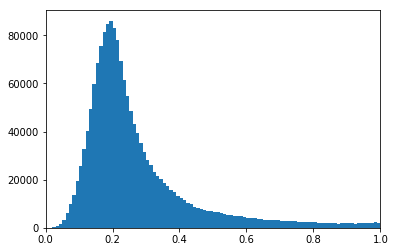

2015 1876961 [ 0.693] 5.32776120548e-07 0.0


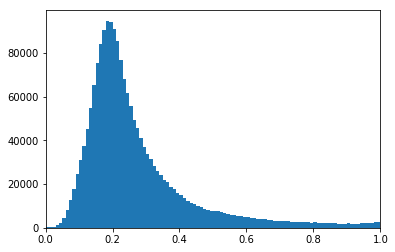

2016 1908411 [ 0.682] 0.0 0.0


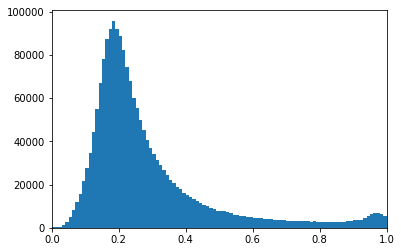

2017 1383190 [ 0.744] 0.0 0.0


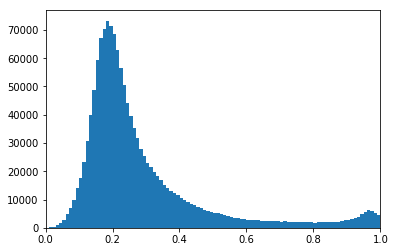

In [45]:
print "look at their ratio"
for year in years:
    aa=c.loc[:,year]
    bb=d.loc[:,year]
    ab=pd.concat([aa,bb],axis=1)
    ind=(~ab.iloc[:,0].isnull()) & ~ab.iloc[:,1].isnull()
    n1=np.sum(ind)
    if n1<1: 
        print year, 'missing'
        continue    
    n4=data_dict[year].shape[0]
    print year,n1,np.round([float(n1)/n4],3), np.mean(aa[ind]<=0), np.mean(bb[ind]<=0)
    ind2=ind & ((aa>0) & (bb>0))
    ratios=bb[ind2]/(bb[ind2]+aa[ind2])
    plt.hist(ratios,bins=100);xlim([0,1]);plt.show()
    #break

In [46]:
print """

"""

### land vs total

In [47]:
c=get_col(u'improvementmarketvalue')
d=get_col(u'landmarketvalue')

In [48]:
for year in years:
    aa=c.loc[:,year]
    bb=d.loc[:,year]
    ab=pd.concat([aa,bb],axis=1)
    n1=np.sum((~ab.iloc[:,0].isnull()) & ab.iloc[:,1].isnull())
    n2=np.sum((ab.iloc[:,0].isnull()) & ~ab.iloc[:,1].isnull())
    n3=np.sum((~ab.iloc[:,0].isnull()) & ~ab.iloc[:,1].isnull())
    n4=data_dict[year].shape[0]
    if n4<1: 
        print year, 'missing'
        continue       
    print year,n1,n2,n3,n4,np.round([float(n1)/n4,float(n2)/n4,float(n3)/n4,float(n4-n1-n2-n3)/n4],3)

2007 13158 48828 1383974 1954010 [ 0.007  0.025  0.708  0.26 ]
2008 14170 50134 1430540 1985405 [ 0.007  0.025  0.721  0.247]
2009 22066 47739 1416068 2037923 [ 0.011  0.023  0.695  0.271]
2010 27830 72743 1798121 2540726 [ 0.011  0.029  0.708  0.253]
2011 24516 67663 1835419 2602464 [ 0.009  0.026  0.705  0.259]
2012 24934 66961 1798271 2572285 [ 0.01   0.026  0.699  0.265]
2013 30873 64020 1802081 2363471 [ 0.013  0.027  0.762  0.197]
2014 21723 74187 1781006 2416002 [ 0.009  0.031  0.737  0.223]
2015 34782 91528 2021410 2709655 [ 0.013  0.034  0.746  0.207]
2016 31047 72842 2114648 2798611 [ 0.011  0.026  0.756  0.207]
2017 12025 48461 1448918 1859695 [ 0.006  0.026  0.779  0.188]


In [ ]:
print "most of them are null consistent   "

most of them are null consistent   


look at their ratio
2007 1383974 [ 0.708] 0.0 0.0


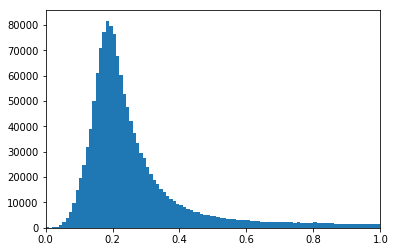

2008 1430540 [ 0.721] 0.0 0.0


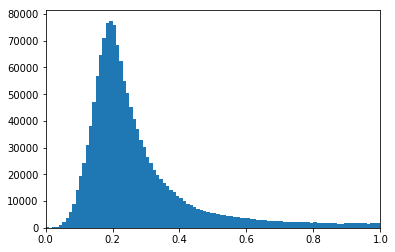

2009 1416068 [ 0.695] 0.0 0.0


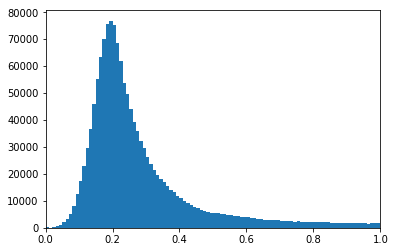

2010 1798121 [ 0.708] 0.0 0.0


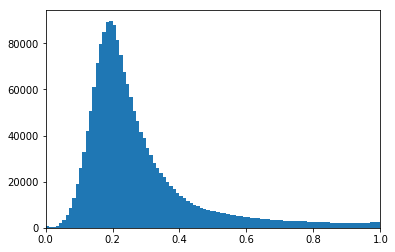

2011 1835419 [ 0.705] 0.0 0.0


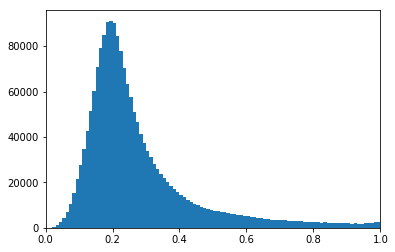

2012 1798271 [ 0.699] 0.0 0.0


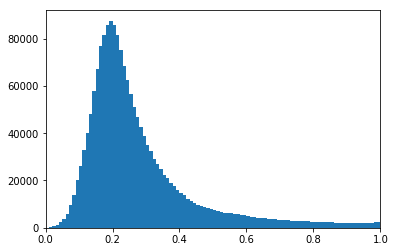

2013 1802081 [ 0.762] 0.0 0.0


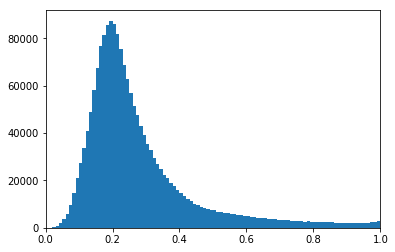

2014 1781006 [ 0.737] 0.0 0.0


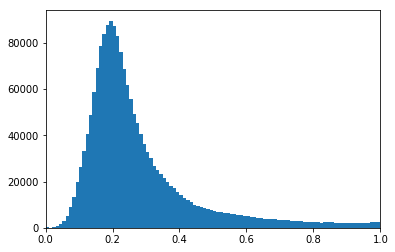

2015 2021410 [ 0.746] 0.0 0.0


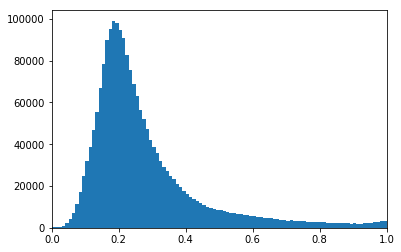

2016 2114648 [ 0.756] 0.0 0.0


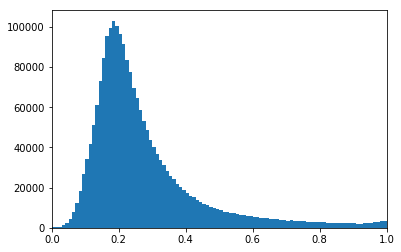

2017 1448918 [ 0.779] 0.0 0.0


In [ ]:
print "look at their ratio"
for year in years:
    aa=c.loc[:,year]
    bb=d.loc[:,year]
    ab=pd.concat([aa,bb],axis=1)
    ind=(~ab.iloc[:,0].isnull()) & ~ab.iloc[:,1].isnull()
    n1=np.sum(ind)
    if n1<1: 
        print year, 'missing'
        continue       
    n4=data_dict[year].shape[0]
    print year,n1,np.round([float(n1)/n4],3), np.mean(aa[ind]<=0), np.mean(bb[ind]<=0)
    ind2=ind & ((aa>0) & (bb>0))
    ratios=bb[ind2]/(bb[ind2]+aa[ind2])
    plt.hist(ratios,bins=100);xlim([0,1]);plt.show()
    #break

In [ ]:
print """

"""